In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt

In [452]:
class Value:
    def __init__(self, data=1, children=[], _backward=lambda: None, _op=''):
        self.data = data
        self.children = children
        self._backward = _backward
        self.grad = 0
        self._op = _op
    
    def log(self):
        def _backward():
            self.grad += (1 / self.data) * out.grad
        out = Value(math.log(self.data), children=[self], _backward=_backward, _op='log')
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), _op='+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        out = Value(0.1*self.data if self.data < 0 else self.data, children=[self], _op='relu')

        def _backward():
            self.grad += (1 if out.data > 0 else 0.1) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        def _backward():
            self.grad += (1 - pow(out.data, 2)) * out.grad
        out = Value(math.tanh(self.data), children=[self], _backward=_backward, _op='tanh')
        return out
    
    def sigmoid(self):
        def _backward():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out = Value(1/(1+math.pow(math.e, -self.data)), children=[self], _backward=_backward)
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other * (self.data ** (other - 1)) * out.grad
            out = Value(self.data ** other, children=[self], _backward=_backward, _op=f'**{other}')
        
        elif isinstance(other, Value):
            def _backward():
                self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
                other.grad += math.log(self.data) * (self.data ** other.data) * out.grad
            out = Value(self.data ** other.data, children=[self, other], _backward=_backward, _op=f'**{other.data}')
        
        return out
    
    def exp(self):
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out = Value(math.exp(self.data), children=[self], _backward=_backward, _op='exp')
        return out
    
    def __repr__(self):
        return f'data: {self.data}, grad: {self.grad}, op: {self._op}'
    
    def backward(self):
        topo = []
        visited = set()

        def visit(node):
            if node not in visited:
                visited.add(node)
                for children in node.children:
                    visit(children)
                topo.append(node)

        self.grad = 1
        visit(self)
        for item in reversed(topo):
            item._backward()

    def step(self):
        topo = []
        visited = set()

        def visit(node):
            if node not in visited:
                visited.add(node)
                for children in node.children:
                    visit(children)
                topo.append(node)

        self.grad = 1
        visit(self)
        for item in reversed(topo):
            item.data -= item.grad * 0.01

    def __sub__(self, other):
            return self + (-other)
    
    def __rpow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other ** self.data * math.log(other) * out.grad
            out = Value(other ** self.data, children=[self], _backward=_backward, _op=f'**{other}')
            return out

    def __rsub__(self, other):
        return (self*-1) + other
    
    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        if isinstance(other, Value):
            def _backward():
                self.grad += 1 / other.data * out.grad
                other.grad -= self.data / (other.data ** 2) * out.grad
            out = Value(self.data / other.data, children=[self, other], _backward=_backward, _op='÷')
            return out
        elif isinstance(other, (float, int)):
            def _backward():
                self.grad += 1 / other * out.grad
            out = Value(self.data / other, children=[self], _backward=_backward, _op='÷')
            return out


In [513]:
import numpy as np
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self):
        return np.array([])

class Neuron(Module):

    def __init__(self, nin, nonlinear=True):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlinear = nonlinear

    def __call__(self, x):
        out = sum(w * x_ for w, x_ in zip(self.w, x)) + self.b
        return out.tanh() if self.nonlinear else out
    
    def parameters(self):
        return self.w + [self.b]

class Model(Module):
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return np.array([p for layer in self.layers for p in layer.parameters()])


class Embedding(Module):
    def __init__(self, embedding_dim, num_embeddings):
        self.embeddings = np.array([Value(random.uniform(-1, 1)) for _ in range(embedding_dim * num_embeddings)]).reshape((num_embeddings, embedding_dim))
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

    def __call__(self, indices):
        return self.embeddings[np.array(indices, dtype=int)].flatten()

    def parameters(self):
        return self.embeddings.flatten()

class Linear(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)] 

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]  # This remains a list comprehension
        return out if len(out) > 1 else out[0]
    
    def parameters(self):
        return np.array([p for neuron in self.neurons for p in neuron.parameters()])
    
class Bob:
    def cross_entropy(logits, actual):
        maxVal = max([num.data for num in logits])

        exp = [(2**(num-maxVal)) for num in logits]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(actual)].log()*-1

        return loss

# class MLP(Module):
#     def __init__(self, nin, nouts):
#         layers = [nin] + nouts
#         self.layers = [Linear(layers[i], layers[i+1], nonlinear=(i!=len(nouts)-1)) for i in range(len(layers)-1)]
    
#     def __call__(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x

#     def parameters(self):
#         return [p for layer in self.layers for neuron in layer.neurons for p in neuron.parameters()]
    
#     def equation(self):
#         val = ''
#         layerEquations = []

#         for layer in self.layers:

#             neuronEquations = []
#             for neuron in layer.neurons:

#                 equation = ''
#                 if len(layerEquations) == 0:

#                     for w in neuron.w:
#                         equation += f'{w.data:.2f}X + '

#                 else:
#                     for w in neuron.w:
#                         equation += f'{w.data:.2f}({layerEquations[-1]}) + '

#                 if neuron.nonlinear:
#                     neuronEquations.append(f'tanh({equation}) + {neuron.b.data} + ')
#                 else:
#                     neuronEquations.append(f'{equation}{neuron.b.data} + ')

#             fullLayerEquation = ''

#             for neuronEquation in neuronEquations:
#                 fullLayerEquation += neuronEquation

#             layerEquations.append(fullLayerEquation)

#         for layerEquation in layerEquations:
#             val += layerEquation
        
#         return val.replace(' + )', '').replace(' + ,', '')[:-3]


In [514]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [589]:
l1 = Linear(1, 50)
l2 = Linear(50, 1, nonlinear=False)

model = Model([l1, l2])

In [610]:
X = np.random.uniform(-2, 2, 1000)
Y = X**2

  0%|          | 0/100 [00:00<?, ?it/s]

loss: 0.1023: 100%|██████████| 100/100 [00:00<00:00, 155.33it/s]   


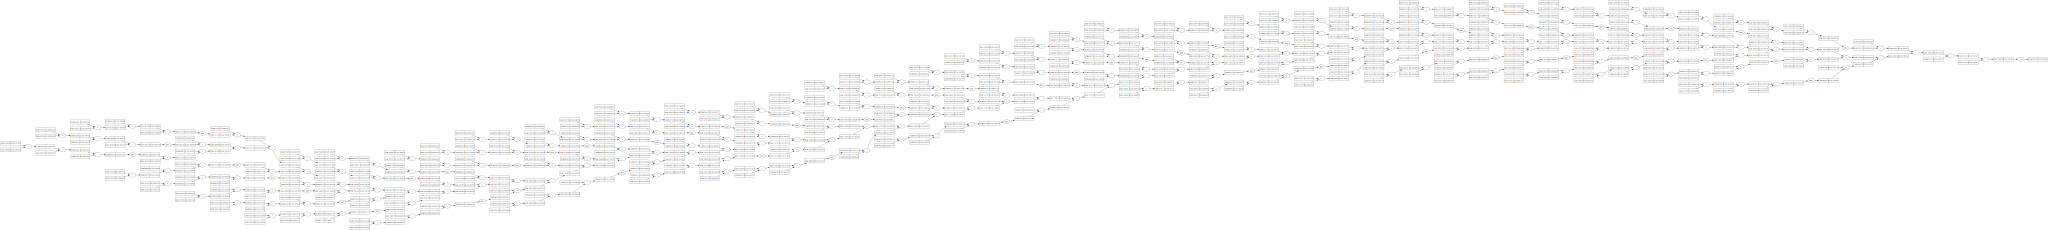

In [598]:
for _ in (t:=trange(100)):
    ix = np.random.randint(0, X.shape[0], (1,))
    logits = model(X[ix])

    loss = (logits - Y[ix])**2

    model.zero_grad()

    loss.backward()

    loss.step()
    
    t.set_description(f'loss: {loss.data[0]:.4}')
    
draw_dot(loss)

In [602]:
out = model([1.5])
out

data: [2.15170467], grad: 0, op: +

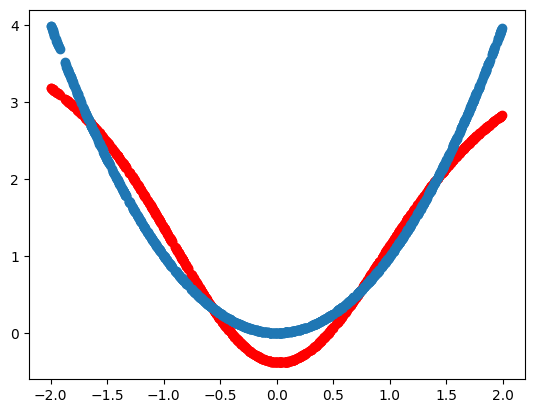

In [612]:
plt.scatter(X, np.array([model([x]).data for x in X]), c='r')
plt.scatter(X, Y)

In [277]:
for _ in (t:=trange(10000)):
    ix = torch.randint(0, X.shape[0], (32,))
    logits = model(X[ix])
    loss = F.cross_entropy(logits, Y[ix])

    optim.zero_grad()

    loss.backward()

    optim.step()
    t.set_description(f'loss: {loss.item()}')

  0%|          | 0/10000 [00:00<?, ?it/s]


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not Value

In [340]:
for _ in range(10):
    word = ''
    context = [0] * context_len
    while True:
        out = model(torch.tensor([context]))
        probs = F.softmax(out)
        ix = torch.multinomial(probs, num_samples=1)[0].item()
        word += itos[ix]
        context = context[1:] + [ix]
        if ix == 0:
            print(word)
            break

tomadoy.
opnicting.
intransmet.
quarter.
backn.
maniah.
intenvitica.
simouncy.
inamy.
nutout.


/var/folders/7m/w8k84tcn19d4k10r234_g4lr0000gn/T/ipykernel_34045/2618988002.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(out)


In [39]:
C = torch.randn(feature_count, 27)
W1 = torch.randn(feature_count*context_len, 200)
b1 = torch.randn(200)
W2 = torch.randn(200, 27)
b2 = torch.randn(27)

In [ ]:
lambda_reg = 0.01
batch_size = 16

for _ in (t:=trange(5)):
    batch_loss = 0  # Initialize loss for the batch

    # Accumulate gradients over the batch
    for _ in range(batch_size):
        ix = int(numpy.random.randint(0, X.shape[0], (1,)))

        input = [[0.] * 27 for _ in range(X.shape[1])]

        for i in range(X.shape[1]):
            input[i][int(X[ix][i])] = 1.0

        out = model(list(np.array(input).flatten()))

        expected = Y[ix]

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(Y[ix])].log()*-1
        batch_loss += loss.data  # Accumulate loss

        loss.backward()

    # Update parameters after processing the batch
    for p in model.parameters():
        p.data -= p.grad * 0.1 / batch_size + lambda_reg * p.data**2 
        p.grad = 0
    
    t.set_description(f'Average batch loss: {batch_loss / batch_size:.2f}')

In [ ]:
ix = int(numpy.random.randint(0, X.shape[0], (1,)))

input = [[0.] * 27 for _ in range(X.shape[1])]

for i in range(X.shape[1]):
    input[i][int(X[ix][i])] = 1.0

out = model(list(np.array(input).flatten()))
expected = Y[ix]

maxVal = max([num.data for num in out])

exp = [(2**(num-maxVal)) for num in out]


count = sum([num.data for num in exp])

prob = [val/count for val in exp]

loss = prob[int(Y[ix])].log()*-1

predict = (0, 0)
for i, p in enumerate(prob):
    if p.data > predict[1]:
        predict = (i, p.data)

print(f'input: {list(np.array(input).flatten())} predicted: {predict}, actual: {expected}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange

In [ ]:
model = MLP(10, [1])

In [ ]:
minRange = -100
maxRange = 100

In [ ]:
X = np.linspace(minRange, maxRange, 100)
Y = np.linspace(minRange, maxRange, 100)
A = np.linspace(minRange, maxRange, 100)
B = np.linspace(minRange, maxRange, 100)
C = np.linspace(minRange, maxRange, 100)
D = np.linspace(minRange, maxRange, 100)
E = np.linspace(minRange, maxRange, 100)
F = np.linspace(minRange, maxRange, 100)
G = np.linspace(minRange, maxRange, 100)
H = np.linspace(minRange, maxRange, 100)

random.shuffle(X)
random.shuffle(Y)
random.shuffle(A)
random.shuffle(B)
random.shuffle(C)
random.shuffle(D)
random.shuffle(E)
random.shuffle(F)
random.shuffle(G)
random.shuffle(H)


def Z(x, y, a, b, c, d, e, f, g, h):
    return x + 33*y + 2*a + 3*b + 4*c + 5*d + 6*e + 33*f - 10*g + 0.5*h + 3

In [ ]:

for _ in (t:=trange(100)):
    loss_avg = 0
    random.shuffle(X)
    random.shuffle(Y)
    random.shuffle(A)
    random.shuffle(B)
    random.shuffle(C)
    random.shuffle(D)
    random.shuffle(E)
    random.shuffle(F)
    random.shuffle(G)
    random.shuffle(H)
    for x in X[:2]:
        for y in Y[:2]:
            for a in A[:2]:
                for b in B[:2]:
                    for c in C[:2]:
                        for d in D[:2]:
                            for e in E[:2]:
                                for f in F[:2]:
                                    for g in G[:2]:
                                        for h in H[:2]:
                                            out = model([x, y, a, b, c, d, e, f, g, h])

                                            loss = (out-Z(x, y, a, b, c, d, e, f, g, h))**2

                                            loss_avg += loss.data

                                            loss.backward()

                                            for p in model.parameters():
                                                p.data -= 0.00001 * p.grad
                                                p.grad = 0

    t.set_description(f'{loss_avg / (X.shape[0]*Y.shape[0])}')

In [ ]:
ix = np.random.randint(-100, 100, (1,))
iy = np.random.randint(-100, 100, (1,))
ia = np.random.randint(-100, 100, (1,))
ib = np.random.randint(-100, 100, (1,))
ic = np.random.randint(-100, 100, (1,))
id = np.random.randint(-100, 100, (1,))
ie = np.random.randint(-100, 100, (1,))
iff = np.random.randint(-100, 100, (1,))
ig = np.random.randint(-100, 100, (1,))
ih = np.random.randint(-100, 100, (1,))

out = model([ix, iy, ia, ib, ic, id, ie, iff, ig, ih])

print(f'diff: {out-Z(ix, iy, ia, ib, ic, id, ie, iff, ig, ih)}')

# loss = (out-z)**2

In [ ]:
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)

X, Y = np.meshgrid(X, Y)

Z_predicted = np.array([model([x, y]).data for x, y in zip(X.flatten(), Y.flatten())])

# Reshape Z_predicted to match the shape of X and Y
Z_predicted = Z_predicted.reshape(X.shape)

print(Z_predicted.shape)

Z = X + 33*Y + 8

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_predicted, color='red', label='Predicted Z')
ax.plot_surface(X, Y, Z, alpha=0.5, color='blue', label='Actual Z')

In [ ]:
model = MLP(1, [1])

In [ ]:
X = np.random.uniform(-5, 5, 1000)
Y = X**3 + X**2 + X + 9

In [ ]:
for _ in (t:=trange(100)):
    loss_avg = 0
    count = 0
    for x, y in zip(X, Y):  
        out = model([x**3 + x**2 + x])

        loss = (out - y)**2

        loss_avg += loss.data
        count += 1

        loss.backward()

        for p in model.parameters():
            p.data -= 0.00001 * p.grad
            p.grad = 0

    t.set_description(f'loss: {loss_avg / max(count, 1)}')

In [ ]:
Y_predicted = np.array([model([x**3 + x**2 + x]).data for x in X])

plt.scatter(X, Y, label='Actual')
plt.scatter(X, Y_predicted, label='Predicted')

plt.legend()


In [ ]:
# bottleneck effect

X = np.random.uniform(-1, 1, 100)
Y = np.random.uniform(-1, 1, 100)
A = np.random.uniform(-1, 1, 100)
B = np.random.uniform(-1, 1, 100)
C = np.random.uniform(-1, 1, 100)
D = np.random.uniform(-1, 1, 100)
E = np.random.uniform(-1, 1, 100)
F = np.random.uniform(-1, 1, 100)
G = np.random.uniform(-1, 1, 100)
H = np.random.uniform(-1, 1, 100)

def Z(x, y, a, b, c, d, e, f, g, h):
    return [[x+y+a+b+c+d+e+f+g+h],[2*x+2*y+2*a+2*b+3*c+8*d+9*e+f+g+h],[8*x+8*y+8*a+8*b+3*c+8*d+9*e+f+g+h],[11*x+11*y+11*a+11*b+3*c+8*d+9*e+f+g+h], [x+y+a+b+c+d+e+f+g+h],[2*x+2*y+2*a+2*b+3*c+8*d+9*e+f+g+h],[8*x+8*y+8*a+8*b+3*c+8*d+9*e+f+g+h],[11*x+11*y+11*a+11*b+3*c+8*d+9*e+f+g+h], [x+y+a+b+c+d+e+f+g+h],[2*x+2*y+2*a+2*b+3*c+8*d+9*e+f+g+h],[8*x+8*y+8*a+8*b+3*c+8*d+9*e+f+g+h],[11*x+11*y+11*a+11*b+3*c+8*d+9*e+f+g+h]]

In [ ]:
model = MLP(10, [12])

In [ ]:
i = 0
avg_loss = 0
count = 0
for _ in (t:=trange(10000)):
    X = np.random.uniform(-1, 1, 100)
    Y = np.random.uniform(-1, 1, 100)
    A = np.random.uniform(-1, 1, 100)
    B = np.random.uniform(-1, 1, 100)
    C = np.random.uniform(-1, 1, 100)
    D = np.random.uniform(-1, 1, 100)
    E = np.random.uniform(-1, 1, 100)
    F = np.random.uniform(-1, 1, 100)
    G = np.random.uniform(-1, 1, 100)
    H = np.random.uniform(-1, 1, 100)
    i += 1

    for x in X[:1]:
        for y in Y[:1]:
            for a in A[:1]:
                for b in B[:1]:
                    for c in C[:1]:
                        for d in D[:1]:
                            for e in E[:1]:
                                for f in F[:1]:
                                    for g in G[:1]:
                                        for h in H[:1]:
                                            out = model([x, y, a, b, c, d, e, f, g, h])
                                            z = Z(x, y, a, b, c, d, e, f, g, h)
                                            loss = (out[0]-z[0][0])**2 + (out[1]-z[1][0])**2 + (out[2]-z[2][0])**2 + (out[3]-z[3][0])**2 + (out[4]-z[4][0])**2 + (out[5]-z[5][0])**2 + (out[6]-z[6][0])**2 + (out[7]-z[7][0])**2 + (out[8]-z[8][0])**2 + (out[9]-z[9][0])**2 + (out[10]-z[10][0])**2 + (out[11]-z[11][0])**2

                                            avg_loss += loss.data
                                            count += 1

                                            loss.backward()

                                            for p in model.parameters():
                                                p.data -= 0.0001 * p.grad
                                                p.grad = 0

print(f'loss: {avg_loss/(max(count, 1))}')


In [ ]:
bottleneck_model = MLP(10, [2, 12])

In [ ]:
i = 0
avg_loss = 0
count = 0
for _ in (t:=trange(10000)):
    X = np.random.uniform(-1, 1, 100)
    Y = np.random.uniform(-1, 1, 100)
    A = np.random.uniform(-1, 1, 100)
    B = np.random.uniform(-1, 1, 100)
    C = np.random.uniform(-1, 1, 100)
    D = np.random.uniform(-1, 1, 100)
    E = np.random.uniform(-1, 1, 100)
    F = np.random.uniform(-1, 1, 100)
    G = np.random.uniform(-1, 1, 100)
    H = np.random.uniform(-1, 1, 100)
    i += 1

    for x in X[:1]:
        for y in Y[:1]:
            for a in A[:1]:
                for b in B[:1]:
                    for c in C[:1]:
                        for d in D[:1]:
                            for e in E[:1]:
                                for f in F[:1]:
                                    for g in G[:1]:
                                        for h in H[:1]:
                                            out = bottleneck_model([x, y, a, b, c, d, e, f, g, h])
                                            z = Z(x, y, a, b, c, d, e, f, g, h)
                                            loss = (out[0]-z[0][0])**2 + (out[1]-z[1][0])**2 + (out[2]-z[2][0])**2 + (out[3]-z[3][0])**2 + (out[4]-z[4][0])**2 + (out[5]-z[5][0])**2 + (out[6]-z[6][0])**2 + (out[7]-z[7][0])**2 + (out[8]-z[8][0])**2 + (out[9]-z[9][0])**2 + (out[10]-z[10][0])**2 + (out[11]-z[11][0])**2

                                            avg_loss += loss.data
                                            count += 1

                                            loss.backward()

                                            for p in bottleneck_model.parameters():
                                                p.data -= 0.0001 * p.grad
                                                p.grad = 0

print(f'loss: {avg_loss/(max(count, 1))}')

In [ ]:
model = MLP(2, [3])

In [ ]:
import math
import torch

In [ ]:
avg_loss = 0
count = 10_000
for _ in (t:=trange(count)):
    ix = np.random.randint(0, X.shape[0], (1,)).item()
    iy = np.random.randint(0, Y.shape[0], (1,)).item()

    k = Z(X[ix], Y[iy])
    
    out = model([X[ix], Y[iy]])

    exp = [(math.e**(v)) for v in out]

    countV = sum([v.data for v in exp])

    prob = [val/countV for val in exp]

    loss = prob[k].log()

    avg_loss += loss.data

    loss.backward()

    for p in model.parameters():
        p.data += 0.0000001 * p.grad
        p.grad = 0

    t.set_description(f'prob: {prob[k]}')
print(f'avg loss: {-avg_loss/count}')

In [ ]:
correct = 0
trials = 10_000
for _ in range(trials):
    ix = np.random.randint(0, X.shape[0], (1,)).item()
    iy = np.random.randint(0, Y.shape[0], (1,)).item()

    k = Z(X[ix], Y[iy], A[ia])
        
    out = model([X[ix], Y[iy], A[ia]])

    exp = [(math.e**(v)) for v in out]

    countV = sum([v.data for v in exp])

    prob = [val/countV for val in exp]

    if prob[k].data == max([p.data for p in prob]):
        correct += 1
    
print(f'accuracy: {correct/trials*100:.2f}%')

In [ ]:
out = {}
for _ in range(100_000):
    ix = np.random.randint(0, X.shape[0], (1,)).item()
    iy = np.random.randint(0, Y.shape[0], (1,)).item()

    k = Z(X[ix], Y[iy])
    out[k] = out.get(k, 0) + 1

print(out)

In [ ]:
import numpy as np

In [ ]:
# multi class 
X = np.random.uniform(-10, 10, 1000)
Y = np.random.uniform(-10, 10, 1000)
A = np.random.uniform(-10, 10, 1000)
B = np.random.uniform(-10, 10, 1000)

def Z(x, y, a, b):
    value = np.sin(x) * np.cos(y) + np.tanh(a * b)

    if value < -0.5:
        return 0
    elif -0.5 <= value < 0.5:
        return 1
    else:
        return 2

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import trange

In [ ]:
W1 = torch.randn(4, 20) * 0.01
b1 = torch.randn(20) * 0.0
W2 = torch.randn(20, 3) * 0.01
b2 = torch.randn(3) * 0.0

parameters = [W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
optim = torch.optim.Adam(parameters)
for _ in (t:=trange(10_000)):
    ix = np.random.randint(0, X.shape[0], (1,)).item()
    iy = np.random.randint(0, Y.shape[0], (1,)).item()
    ia = np.random.randint(0, A.shape[0], (1,)).item()
    ib = np.random.randint(0, B.shape[0], (1,)).item()

    k = Z(X[ix], Y[iy], A[ia], B[ib])
    input = torch.tensor([X[ix], Y[iy], A[ia], B[ib]]).float()
    hpreact = input @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    optim.zero_grad()
    
    loss = F.cross_entropy(logits, torch.tensor(k))

    loss.backward()

    optim.step()

    t.set_description(f'loss: {loss.data}')

In [ ]:
correct = 0
trials = 10_000
for _ in range(trials):
    ix = np.random.randint(0, X.shape[0], (1,)).item()
    iy = np.random.randint(0, Y.shape[0], (1,)).item()
    ia = np.random.randint(0, A.shape[0], (1,)).item()
    ib = np.random.randint(0, B.shape[0], (1,)).item()

    k = Z(X[ix], Y[iy], A[ia], B[ib])
    input = torch.tensor([X[ix], Y[iy], A[ia], B[ib]]).float()
    hpreact = input @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2

    probs = F.softmax(logits)

    out = torch.multinomial(probs, num_samples=1)[0].item()

    if torch.argmax(probs) == out:
        correct += 1
    
print(f'accuracy: {correct/trials*100:.2f}%')

In [ ]:
import numpy as np
def fetch(url):
    import requests, gzip, os, hashlib, numpy as np
    fp = os.path.join('tmp/' + hashlib.md5(url.encode('utf-8')).hexdigest() + '.gz')
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = torch.tensor(fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)))
Y_train = torch.tensor(fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:])
X_test = torch.tensor(fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)))
Y_test = torch.tensor(fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:])

In [ ]:
X_train.shape

In [ ]:
W1 = torch.randn(28*28, 200) * 0.01
b1 = torch.randn(200) * 0.0
W2 = torch.randn(200, 100) * 0.01
b2 = torch.randn(100) * 0.0
W3 = torch.randn(100, 10) * 0.01
b3 = torch.randn(10) * 0.0

parameters = [W1, b1, W2, b2, W3, b3]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
optim = torch.optim.Adam(parameters)
for _ in (t:=trange(1000)):
    ix = torch.randint(0, X_train.shape[0], (32,))
    l1 = torch.tanh(X_train[ix].flatten(1).float() @ W1 + b1)
    l2 = torch.tanh(l1 @ W2 + b2)
    logits = l2 @ W3 + b3

    loss = F.cross_entropy(logits, Y_train[ix])

    optim.zero_grad()

    loss.backward()

    optim.step()

    t.set_description(f'loss: {loss.data}')

In [ ]:
correct = 0
trials = 100000
for _ in range(trials):
    ix = torch.randint(0, X_train.shape[0], (1,))
    l1 = torch.tanh(X_train[ix].flatten(1).float() @ W1 + b1)
    l2 = torch.tanh(l1 @ W2 + b2)
    logits = l2 @ W3 + b3

    prob = F.softmax(logits)

    if torch.argmax(prob).item() == Y_train[ix].item():
        correct += 1

print(f'accuracy: {correct/trials}')